# Building a multiclass classification model
> Data cleaning, adding structures to PubChem data, building a multiclass model, dealing with imbalanced data

- toc: True
- branch: master
- badges: true
- comments: true
- categories: [jupyter, multiclass, PubChem, imbalanced]
- image: images/blog/multiclass.png
- hide: false
- search_exclude: false

# Introduction

At the Fall 2021 ACS Meeting, the group from [NCATS](https://opendata.ncats.nih.gov/adme/home) described a number of ADME models they had developed.  Even better, the NCATS team also released some of the data used to build these models.  In this notebook we'll use the data from the [NCATS CYP3A4](https://pubchem.ncbi.nlm.nih.gov/bioassay/1645841) assay to classify molecules as CYP3A4 activators, inhibitors, or inactive.  

In order to run this notebook, the following Python libraries should be installed
- [pandas](https://pandas.pydata.org/) - handling data tables
- [pubchempy](https://pubchempy.readthedocs.io/en/latest/) - grabbing chemical structures from PubChem
- [tqdm](https://github.com/tqdm/tqdm) - progress bars
- [numpy](https://numpy.org/) - linear algebra and matrices
- [itertools](https://docs.python.org/3/library/itertools.html) - advanced list handling
- [sklearn](https://scikit-learn.org/stable/) - machine learning
- [lightgbm](https://lightgbm.readthedocs.io/en/latest/) - gradient boosted trees for machine learning
- [matplotlib](https://matplotlib.org/) - plotting
- [seaborn](https://seaborn.pydata.org/) - even better plotting
- [pingouin](https://pingouin-stats.org/api.html) - stats
- [imbalanced-learning](https://imbalanced-learn.org/stable/) - machine learning with imbalanced datasets

In [1]:
import pandas as pd
import pubchempy as pcp
from tqdm.auto import tqdm
import numpy as np
import itertools
from lib.descriptor_gen import DescriptorGen
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

Enable Pandas progress_apply so that we can get progress bars for Pandas operations

In [2]:
tqdm.pandas()

# Read and clean the PubChem data

In [3]:
df = pd.read_csv("data/AID_1645841_datatable.csv",skiprows=[1,2,3,4,5],low_memory=False)

In [4]:
df

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,Efficacy-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
0,1,104223880,197033.0,Active,43,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,136.1930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11111456,5281670.0,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11113977,6604832.0,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,37.9083,105.9830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,124879150,5280443.0,Active,84,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,6.0081,112.7240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,124879975,836.0,Active,63,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,3.0112,57.7747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,5238,90341041,11957637.0,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5238,5239,90341069,4906.0,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5239,5240,90341160,5593.0,Active,42,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,100.9580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5240,5241,90341654,2968.0,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,1.3450,68.4438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that the data file doesn't have chemical structures as SMILES strings.  We're going to add those using the pubchempy library, which can look up the chemical structure based on the **PUBCHEM_CID** field in our dataframe. This is great, but the pubchempy service will have problems if we pass it a null value.  Let's check and see if we have any null values in our **PUBCHEM_CID** column. 

In [5]:
sum(df.PUBCHEM_CID.isna())

4

We have four null values.  Let's get rid of the rows where **PUBCHEM_CID** is null. 

In [6]:
df[df.PUBCHEM_CID.isna()]

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,Efficacy-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
173,174,144206496,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,1499,170465762,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2611,2612,170466890,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2886,2887,225144377,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can drop the four rows where **PUBCHEM_CID** is null. 

In [7]:
df.dropna(subset=["PUBCHEM_CID"],inplace=True)

In [8]:
df

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,Efficacy-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
0,1,104223880,197033.0,Active,43,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,136.1930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11111456,5281670.0,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11113977,6604832.0,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,37.9083,105.9830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,124879150,5280443.0,Active,84,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,6.0081,112.7240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,124879975,836.0,Active,63,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,3.0112,57.7747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,5238,90341041,11957637.0,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5238,5239,90341069,4906.0,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5239,5240,90341160,5593.0,Active,42,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,100.9580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5240,5241,90341654,2968.0,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,1.3450,68.4438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In order to lookup a structure based on **PUBCHEM_CID** the **PUBCHEM_CID** field must be an integer. Let's take a look at the datatypes for our dataframe. 

In [9]:
df.dtypes

PUBCHEM_RESULT_TAG                    int64
PUBCHEM_SID                           int64
PUBCHEM_CID                         float64
PUBCHEM_ACTIVITY_OUTCOME             object
PUBCHEM_ACTIVITY_SCORE                int64
                                     ...   
Activity at 23.94 uM-Replicate_5    float64
Activity at 57.45 uM-Replicate_5    float64
Activity at 115.4 uM-Replicate_5    float64
Activity at 193.5 uM-Replicate_5    float64
Activity at 288.3 uM-Replicate_5    float64
Length: 203, dtype: object

The **PUBCHEM_CID** field is a float64, which is not what we want.  Let's convert that column to an integer. 

In [10]:
df.PUBCHEM_CID = df.PUBCHEM_CID.astype(int)

The field we want to model is **Phenotype-Replicate_1** which takes one of three values.  Let's look at the possible values and their distribution.  We can see that the class **Activator** is somewhat underrepresented.  We'll start by building a model with the data as provided.  Once we've done this, we'll also take a look at whether we can improve our model by employing strategies to compensate for the data imbalance. 

In [11]:
df['Phenotype-Replicate_1'].value_counts(normalize=True)

Inhibitor    0.580374
Inactive     0.354716
Activator    0.064910
Name: Phenotype-Replicate_1, dtype: float64

In order to build our model, we need the column were predicting to be represented as numeric values.  We can convert the text labels to numbers using the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) method from skikit-learn. 

In [12]:
labels = df['Phenotype-Replicate_1'].unique().tolist()
labels

['Inhibitor', 'Inactive', 'Activator']

In [13]:
le = LabelEncoder()
le.fit(labels)
df['label'] = le.transform(df['Phenotype-Replicate_1'])

Our dataframe has a bunch of extra fields that are not necessary for this analysis.  Let's simplify and create a new dataframe with only fields we care about. 

In [14]:
data_df = df[['PUBCHEM_CID','Phenotype-Replicate_1','label']].copy()
data_df

,PUBCHEM_CID,Phenotype-Replicate_1,label
0,197033,Inhibitor,2
1,5281670,Inactive,1
2,6604832,Inhibitor,2
3,5280443,Inhibitor,2
4,836,Inhibitor,2
...,...,...,...
5237,11957637,Inactive,1
5238,4906,Inactive,1
5239,5593,Inhibitor,2
5240,2968,Inhibitor,2


# Add chemical structures to the PubChem data
Now we'll use pubchempy to look up chemical structures based on **PUBCHEM_CID** and add them to our dataframe.  In order to keep the PubChem server happy, we'll break the **PUBCHEM_CID** list into chunks of 100. 

In [15]:
cmpd_list = []
num_chunks = len(df)/100
for chunk in tqdm(np.array_split(data_df.PUBCHEM_CID,num_chunks)):
    cmpd_list.append(pcp.get_compounds(chunk.tolist()))

  0%|          | 0/52 [00:00<?, ?it/s]

We collected the chemical structures in a list of lists. We need to flatten this into a single list. The operation works something like this 

<pre>[[1,2,3],[4,5,6],[7,8,9]] -> [1,2,3,4,5,6,7,8,9]</pre>

In [16]:
data_df['Compound'] = list(itertools.chain(*cmpd_list))

Extract the **SMILES** from the **Compound** objects in the **Compound** column. 

In [17]:
data_df['SMILES'] = [x.canonical_smiles for x in data_df.Compound]

# Calculate molecular descriptors
Create a **DescriptorGen** object for generating molecular descriptors. 

In [18]:
desc_gen = DescriptorGen()

Add the desecriptors to the dataframe. 

In [19]:
data_df['desc'] = data_df.SMILES.progress_apply(desc_gen.from_smiles)

  0%|          | 0/5238 [00:00<?, ?it/s]

# Split the data into training and test sets

In [20]:
train, test = train_test_split(data_df)
train_X = np.stack(train.desc)
train_y = train.label
test_X = np.stack(test.desc)
test_y = test.label

# Create and evaluate a machine learning model
- Intstantiate a [LighGBM classifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier)
- Train the model 
- Predict on the test set

In [21]:
lgbm = LGBMClassifier()
lgbm.fit(train_X, train_y)
pred = lgbm.predict_proba(test_X)

Evaluate model performance using the ROC AUC score.  Note that this is a little different with a multiclass classifer.  We specify **class='ovo'** which means that we are evaluating "one vs one". We evaluate the AUC for all pairs of classes.  The argument **average='macro'** indicates that the reported AUC is the average of all of the **one vs one** comparisons. 

In [22]:
roc_auc_score(test_y,pred,multi_class='ovo',average='macro')

0.7314209949069332

We can also plot a confusion matrix to examine the model's performance on each of the three classes. 

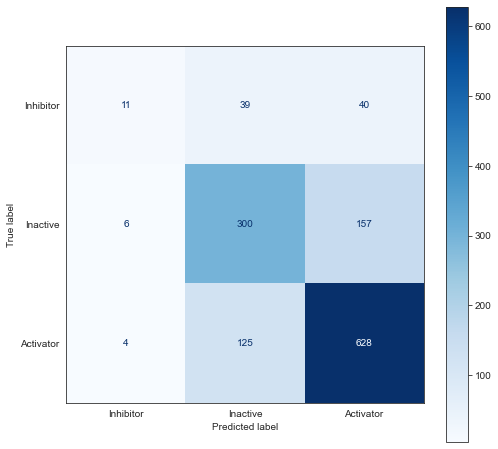

In [23]:
sns.set_style("white")
plt.rcParams["figure.figsize"] = (8,8)
plot_confusion_matrix(lgbm,test_X,test_y,display_labels=labels,cmap=plt.cm.Blues)

# Use oversampling to compensate for imbalanced data
Load the imbalanced-learn library to perform oversampling.  In a simple oversampling approach we repeated sample the imbalanced class(es) to create a balanced dataset. 

In [24]:
from imblearn.over_sampling import RandomOverSampler

We will create an oversampling object and use it to resample our training set. 

In [25]:
ros = RandomOverSampler()
resample_X, resample_y = ros.fit_resample(train_X,train_y)

Recall that our original training set is somewhat imbalanced.  The minority class (0 or Activator) only accounts for ~7% of the data. 

In [26]:
pd.Series(train_y).value_counts()

2    2283
1    1395
0     250
Name: label, dtype: int64

After oversampling the dataset is balanced. 

In [27]:
pd.Series(resample_y).value_counts()

0    2283
1    2283
2    2283
Name: label, dtype: int64

Build a model with the balanced, oversampled data

In [28]:
resample_lgbm = LGBMClassifier()
resample_lgbm.fit(resample_X, resample_y)

LGBMClassifier()

Make a prediction with the new model, built with the resampled data. 

In [29]:
resample_pred = resample_lgbm.predict_proba(test_X)
roc_auc_score(test_y,resample_pred,multi_class='ovr',average='macro')

0.7711599173637508

As above, we can plot a confusion matrix to examine the performance of the classifier trained on the oversampled data. Let's put the two confusion matrices side by side to compare.  

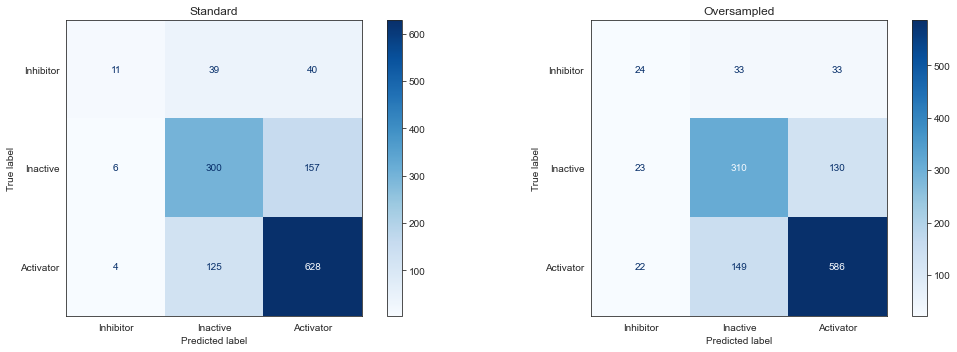

In [30]:
sns.set_style("white")
classifiers = [lgbm,resample_lgbm]
titles = ["Standard","Oversampled"]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for cls,ax,title in zip(classifiers, axes, titles):
    plot_confusion_matrix(cls,test_X,test_y,display_labels=labels,cmap=plt.cm.Blues,ax=ax)
    ax.title.set_text(title)
plt.tight_layout()

# Comparing the standard and oversampled models
Let's see if there is a difference in AUC between the Standard and Resampled models.  In order to compare we'll perform ten rounds of cross validation.  

In [31]:
res = []
for i in tqdm(range(0,10)):
    # split the data into training and test sets
    train, test = train_test_split(data_df)
    train_X = np.stack(train.desc)
    train_y = train.label
    test_X = np.stack(test.desc)
    test_y = test.label
    # Create the standard model
    lgbm = LGBMClassifier()
    lgbm.fit(train_X,train_y)
    pred = lgbm.predict_proba(test_X)
    auc = roc_auc_score(test_y,pred,multi_class='ovo',average='macro')
    # Create the resampled model
    resample_lgbm = LGBMClassifier()
    resample_X, resample_y = ros.fit_resample(train_X,train_y)
    resample_lgbm.fit(resample_X, resample_y)
    resample_pred = resample_lgbm.predict_proba(test_X)
    resample_auc = roc_auc_score(test_y,resample_pred,multi_class='ovr',average='macro')
    res.append([auc, resample_auc])

  0%|          | 0/10 [00:00<?, ?it/s]

Create a dataframe with the AUC values using the Standard and Oversampled models

In [32]:
res = np.array(res)
res_df = pd.DataFrame(res,columns=["Standard","Oversampled"])

In [33]:
res_df.head()

,Standard,Oversampled
0,0.754473,0.786771
1,0.734688,0.764611
2,0.748104,0.784988
3,0.750127,0.782358
4,0.756903,0.788311


Reformat the dataframe to combine the two columns in **res_df**

In [34]:
melt_df = res_df.melt()
melt_df.columns = ["Method","AUC"]
melt_df

,Method,AUC
0,Standard,0.754473
1,Standard,0.734688
2,Standard,0.748104
3,Standard,0.750127
4,Standard,0.756903
5,Standard,0.737540
6,Standard,0.758273
7,Standard,0.746824
8,Standard,0.766870
9,Standard,0.756476


Plot the AUC distributions for the Standard and Oversampled models as a kernel density estimate (KDE)

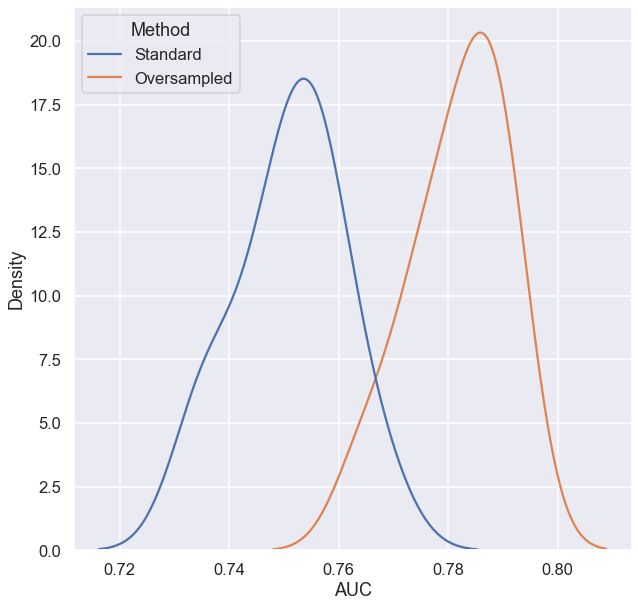

In [35]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_context('talk')
sns.kdeplot(x="AUC",hue="Method",data=melt_df);

Another way of comparing the distributions is to use the plot_paired method available in the pingouin library. Note that the AUC for the Resampled method is always greater than that for the Standard method. 

In [36]:
from pingouin import wilcoxon, plot_paired

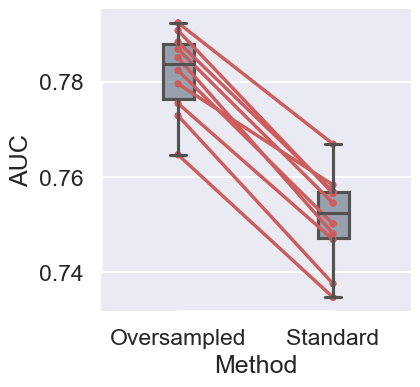

In [37]:
melt_df['cycle'] = list(range(0,10))+list(range(0,10))
plot_paired(data=melt_df,dv="AUC",within="Method",subject="cycle");

In order to compare distributions, we sometime perform a t-test.  However, a t-test assumes that the data is normally distributed. Since we can't make this assumption, we can use the Wilcoxon ranked sum test, which is the non-parametric equivalent to the t-test.  The pingouin library provides a convenient implementation in the **wilcoxon** function. As we can see from the p-value in the table below, the difference in the means of the distributions is statistically significant. 

In [38]:
wilcoxon(res_df.Standard,res_df.Oversampled)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,0.0,two-sided,0.001953,-1.0,0.01
